In [444]:
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np

In [445]:
class Collector(Agent):
    def __init__(self, unique_id: int, model: Model) -> None:
        super().__init__(unique_id, model)
        self.random.seed(12345)

In [446]:
class Explorer(Agent):
    RANDOM_SEED = 12345

    def __init__(self, unique_id: int, model: Model) -> None:
        super().__init__(unique_id, model)
        self.random.seed(self.RANDOM_SEED)

    def move(self) -> None:
        """
        Moves the agent in the grid.
        """

        x, y = self.pos
        half_width = self.model.grid.width // 2

        allowed_x_range = (
            range(x - 1, x + 2) if 0 < x < half_width - 1 else range(x, x + 2)
        )

        allowed_y_range = range(y - 1, y + 2) if y > 0 else range(y, y + 2)

        new_x = self.random.choice(allowed_x_range)
        new_y = self.random.choice(allowed_y_range)

        self.model.grid.move_agent(self, (new_x, new_y))

    def find_food(self) -> None:
        """
        Look for food in the grid.
        """

        x, y = self.pos
        if self.model.food_layer[x][y] > 0:
            self.model.known_food_layer[x][y] = 1

    def step(self) -> None:
        """
        Step through the environment.
        """

        self.move()
        self.find_food()

In [447]:
class NomNomModel(Model):
    RANDOM_SEED = 12345

    __slots__ = (
        "schedule",
        "grid",
        "running",
        "food_layer",
        "known_food_layer",
        "storage_location",
        "datacollector",
    )

    def __init__(self, width: int, height: int, num_agents=5, max_food=47) -> None:
        """
        Initializes the model with the given parameters.

        Args:
            width (int): The width of the grid.
            height (int): The height of the grid.
            num_agents (int): The number of agents to be created.
            max_food (int): The maximum amount of food to be created.
        """

        self.random.seed(self.RANDOM_SEED)

        self.schedule = SimultaneousActivation(self)
        self.grid = MultiGrid(width, height, True)
        self.running = True

        # Layers
        self.food_layer = np.zeros((width, height), dtype=np.int8)
        self.known_food_layer = np.zeros((width, height), dtype=np.int8)

        # Model Instances
        self.spawn_agents(3, Collector, "collector_")
        self.spawn_agents(2, Explorer, "explorer_")
        self.spawn_food(max_food)
        self.place_warehouse()

        # Data Collector
        self.datacollector = DataCollector(
            {
                "Food": lambda m: np.sum(m.food_layer),
                "Known Food": lambda m: np.sum(m.known_food_layer),
                "Agents": lambda m: m.schedule.get_agent_count(),
                "Warehouse location": lambda m: m.storage_location,
            }
        )

    def spawn_agents(
        self, num_agents: int, agent_class: Agent, prefix: str = ""
    ) -> None:
        """
        Spawns the agents in random places of the grid.

        Args:
            num_agents (int): The number of agents to be created.
            agent_class (Agent): The class of the agent to be created.
        """

        used_positions = set()

        for i, _ in enumerate(range(num_agents)):
            while True:
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)

                if (x, y) not in used_positions:
                    agent = agent_class((prefix, i), self)
                    self.grid.place_agent(agent, (x, y))
                    self.schedule.add(agent)

                    used_positions.add((x, y))
                    break

    def spawn_food(self, max_food: int) -> None:
        """
        Spawns the food in random places of the grid. The amount of food spawned
        is between 2 and 5, and there is a 5-step interval between each spawn.
        The total number of spawned boxes is limited to max_food.

        Args:
            max_food (int): The maximum amount of food to be created.
        """

        placed_food = 0
        while placed_food < max_food:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)

            if self.grid.is_cell_empty((x, y)):
                self.food_layer[x][y] = self.random.randrange(2, 6)
                placed_food += self.food_layer[x][y]

    def place_warehouse(self) -> None:
        """
        Places the warehouse in the center of the grid.
        """

        while True:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)

            if self.grid.is_cell_empty((x, y)) and self.food_layer[x][y] == 0:
                self.storage_location = (x, y)
                break

    def step(self) -> None:
        """
        Advances the model by one step.
        """

        self.datacollector.collect(self)
        self.schedule.step()

# Simulation Parameters

The simulation can be adjusted by changing the parameters in the cell below.

- **num_agents (int)**: The number of agents in the simulation.
- **max_food (int)**: The maximum amount of food that spawns in the simulation.
- **grid_size (int)**: The size of the grid in the simulation (grid_size x grid_size).
- **food_spawn_interval (int)**: The interval at which food spawns in the simulation.
- **min_food_per_spawn (int)**: The minimum amount of food that spawns in the simulation.
- **max_food_per_spawn (int)**: The maximum amount of food that spawns in the simulation.


In [448]:
NUM_AGENTS = 5
MAX_FOOD = 47
GRID_SIZE = 20

FOOD_SPAWN_INTERVAL = 5
MIN_FOOD_PER_SPAWN = 2
MAX_FOOD_PER_SPAWN = 5

In [449]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['animation.writer'] = 'ffmpeg'

def plot_simulation(model: NomNomModel, title: str, figsize=(10, 10), cmap="binary") -> None:
    """
    Plots the simulation grid.

    Args:
        model (NomNomModel): The model to be plotted.
        title (str): The title of the plot.
        figsize (tuple, optional): The size of the figure. Defaults to (10, 10).
        cmap (str, optional): The color map to be used. Defaults to "binary".
    """

    data = model.food_layer.copy()

    plt.figure(figsize=figsize)
    heatmap = plt.imshow(data, cmap=cmap)

    # Warehouse location
    warehouse_x, warehouse_y = model.storage_location
    plt.scatter(warehouse_y, warehouse_x, color="black", marker="s", s=50, label="Warehouse")


    for i in range(len(model.food_layer)):
        for j in range(len(model.food_layer[0])):
            box_color = "white" if model.food_layer[i][j] > 0 else "black"

            plt.text(j, i, model.food_layer[i][j], ha="center", va="center", color=box_color)

    plt.colorbar(heatmap)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", bbox_to_anchor=(1, 1), fontsize=12)
    plt.xlabel("aisle", fontsize=14)
    plt.ylabel("shelf", fontsize=14)

    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.show()

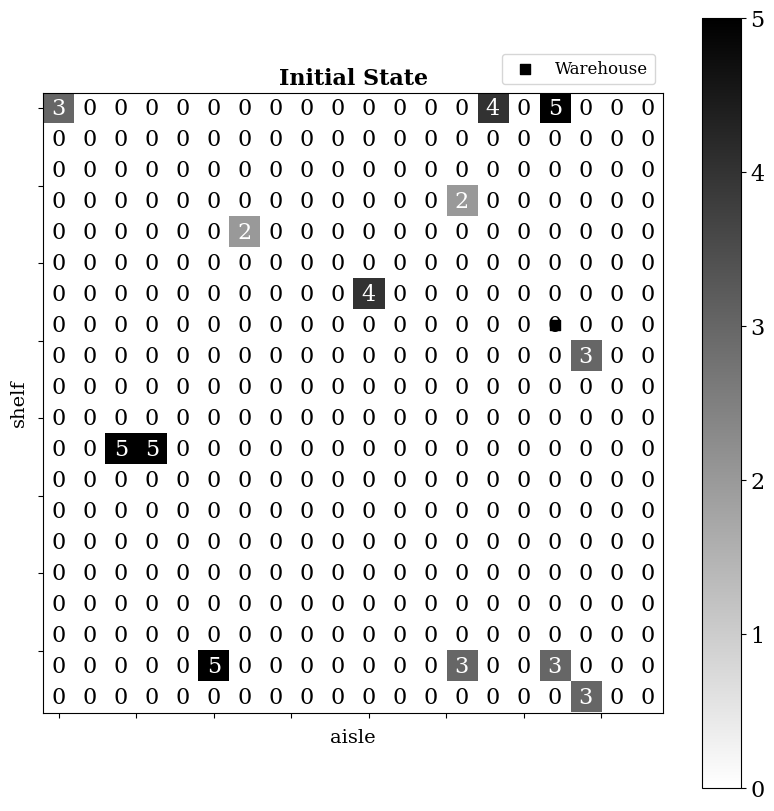

      Food  Known Food  Agents Warehouse location
0       47           0       5            (7, 16)
1       47           0       5            (7, 16)
2       47           0       5            (7, 16)
3       47           0       5            (7, 16)
4       47           0       5            (7, 16)
...    ...         ...     ...                ...
1995    47          12       5            (7, 16)
1996    47          12       5            (7, 16)
1997    47          12       5            (7, 16)
1998    47          12       5            (7, 16)
1999    47          12       5            (7, 16)

[2000 rows x 4 columns]


In [450]:
def run_simulation() -> Model:
    """
    Runs the simulation.
    """

    model = NomNomModel(GRID_SIZE, GRID_SIZE, NUM_AGENTS, MAX_FOOD)
    plot_simulation(model, "Initial State")

    for _ in range(2000):
        model.step()

    return model


model = run_simulation()

print(model.datacollector.get_model_vars_dataframe())